In [1]:
import pandas as pd
from cbcdb import DBManager
import matplotlib.pyplot as  plt
from numpy import nanmean
import seaborn as sns

In [2]:
db = DBManager(profile_name='pwa',
               secret_name='etl/config/env',
               region_name='us-east-1',
               use_aws_secrets=True)


sql = """
with doctor_rev as (
select
    division_name
   , network_id
   , date(revenue_at) as date
   -- Contact and Vet Data
   , veterinarian
   --, product_is_medical
   , sum(revenue) as revenue
   from adham_dev_ezyvet.fct_transactions
   where product_is_medical = 1
   group by 1,2,3,4)
   select
   a.*,
   d.revenue
     from adham_dev_prod.fct_dr_avail_with_agg a
     left join doctor_rev as d
      on a.division_name = d.division_name
        and  a.appointment_date = d.date
         """

df = db.get_sql_dataframe(sql)
#df.to_csv('data/doctor_rev.csv', index=False)

In [3]:
df = pd.read_csv('data/doctor_rev.csv')

#### Convert Data types

In [4]:
# Convert to date
df['appointment_date'] = pd.to_datetime(df['appointment_date'])
# Identify weekday
df['appointment_date_weekday'] = df['appointment_date'].apply(lambda x: x.weekday())
# Free time proportion
df['free_time_prop'] = df.apply(lambda x: 0 if x['free_time']   == 0 else x['free_time']/ (x['free_time']  + x['minutes_in_office'] - x['block_minutes']), axis = 1)
# Revenue per minute
df['rev_per_min'] = df['revenue'] / df['minutes_in_office']
# Revenue per hour
df['rev_per_hour'] = df['rev_per_min'] * 60

#### Filter

In [5]:
df = df[(df.appointment_date > '2022-01-01') & (df.appointment_date < '2022-12-31') ]
df = df[(df['rev_per_hour'] > 0 ) & (df['rev_per_hour'] < 99999 )]

#### Average revenue by weekday

In [6]:
df_rev_wd = df.groupby(['appointment_date_weekday'], as_index=False).agg({'rev_per_hour':['mean','count']}).dropna()
df_rev_wd

appointment_date_weekday rev_per_hour      
                                   mean count
0                        0    54.252541  1486
1                        1    56.098926  1484
2                        2    53.706181  1383
3                        3    59.014124  1421
4                        4    39.942918  1152
5                        5    74.054697   470
6                        6    20.986166     8

sns.set_style("whitegrid")

### Revenue by Day

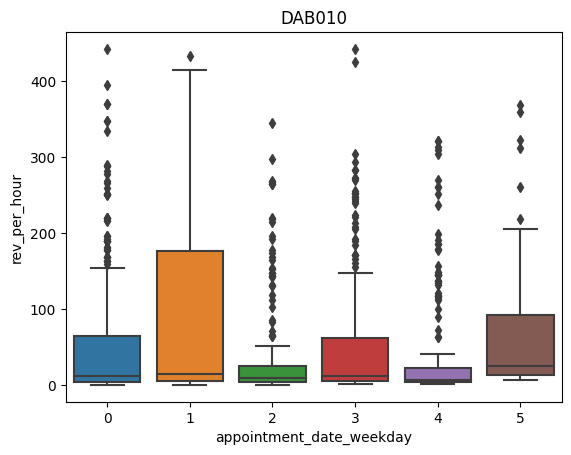

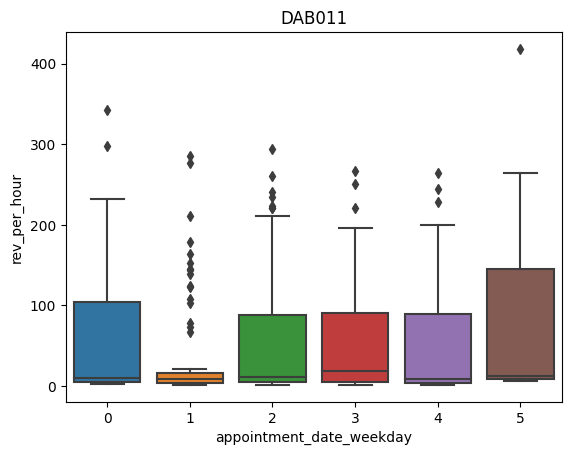

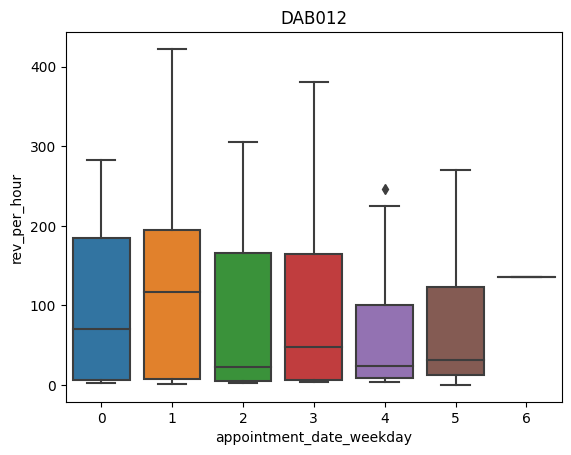

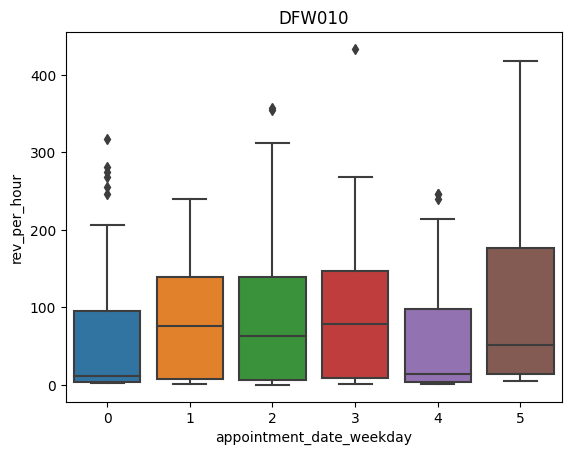

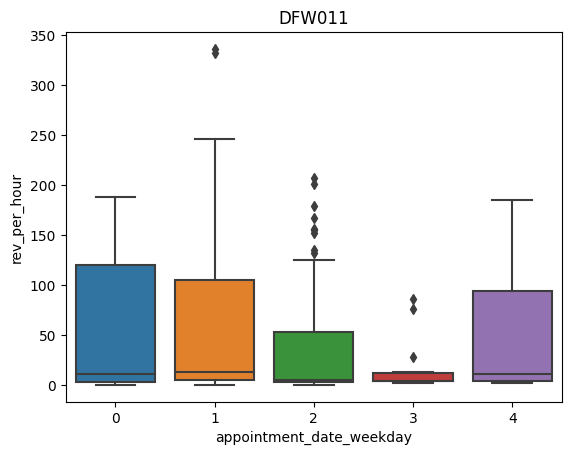

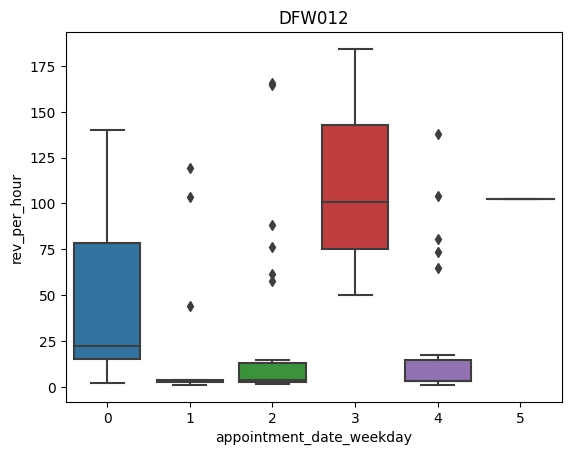

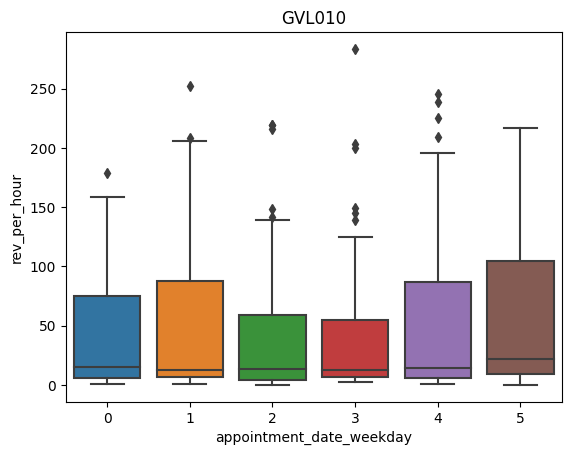

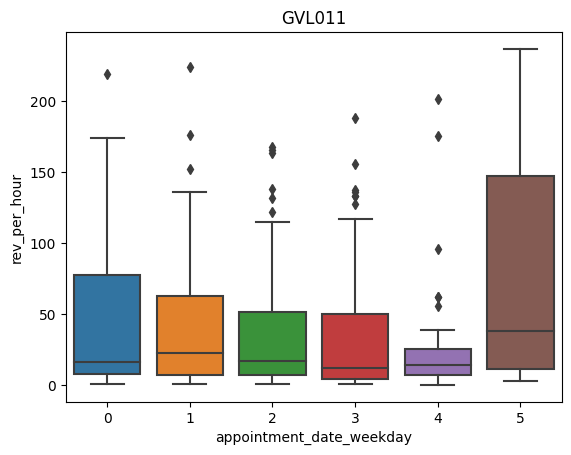

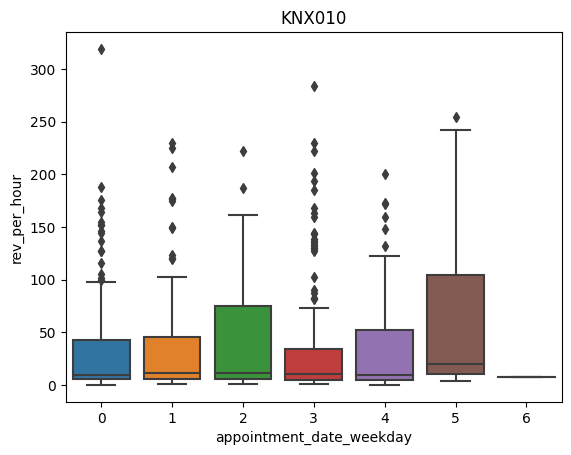

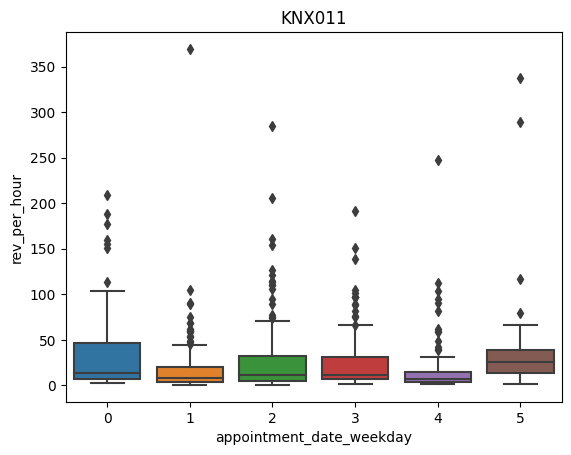

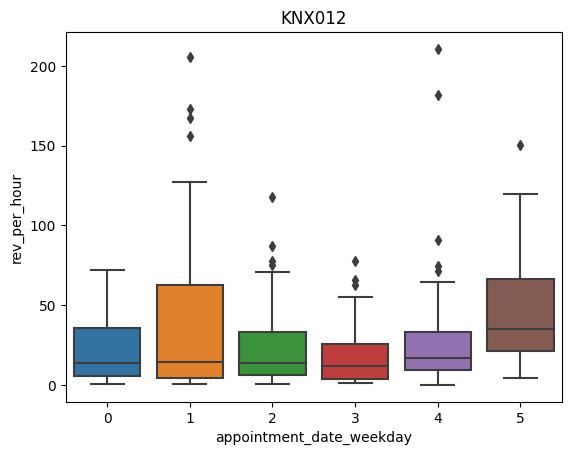

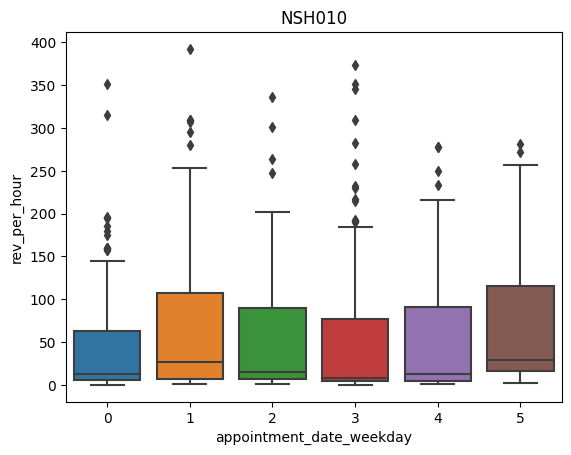

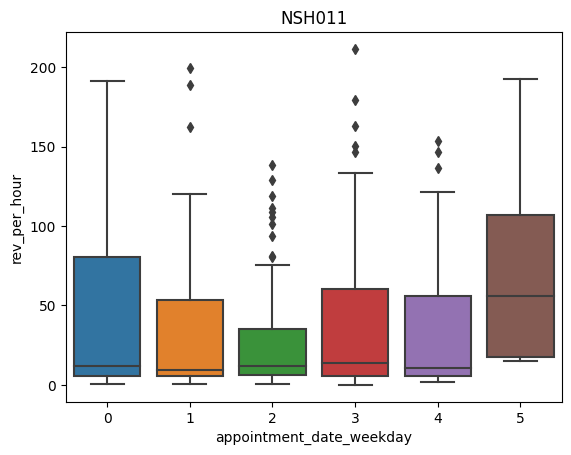

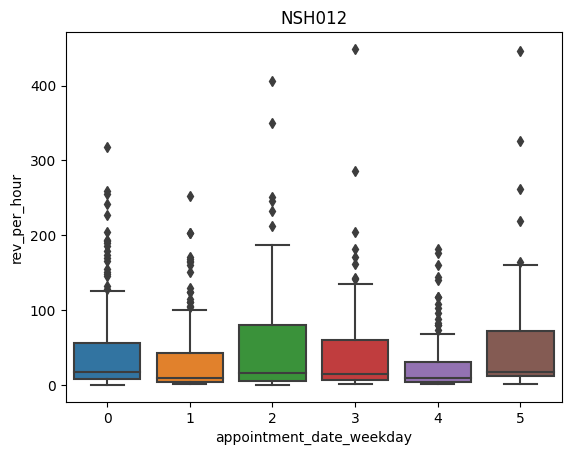

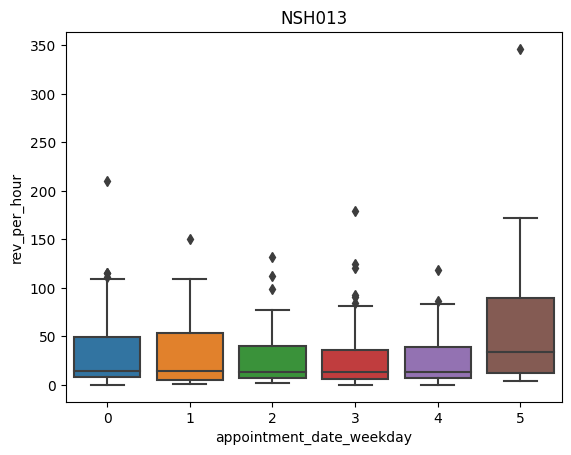

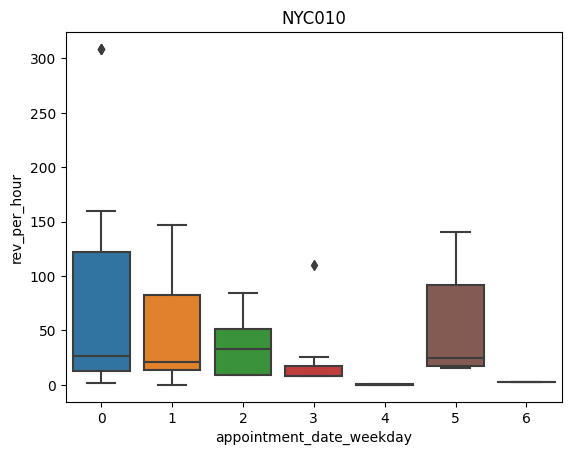

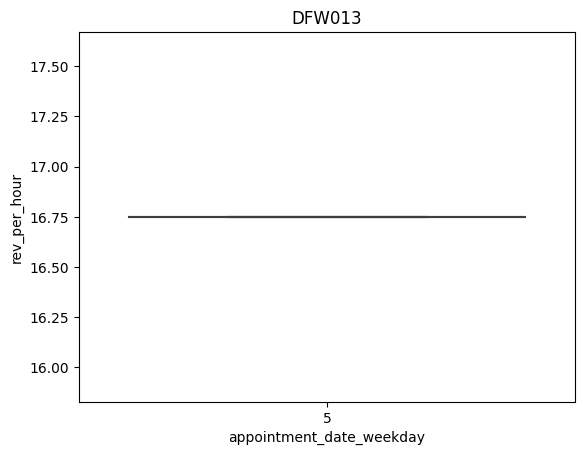

In [17]:
df_rev_wd_dc = df.groupby(['appointment_date_weekday', 'division_name'], as_index=False).agg({'rev_per_hour':'mean'}).dropna()
for d in df_rev_wd_dc.division_name.unique():
  df_temp = df[(df.division_name==d)&(df.rev_per_hour<500)].copy()
  sns.boxplot(data = df_temp, x='appointment_date_weekday',y='rev_per_hour').set_title(d)
  plt.show()

### Revenue by free time proportion

In [9]:
df_work_proportion = df.groupby(['appointment_date_weekday', 'primary_resource_name'], as_index=False).agg({'free_time_prop':'mean'}).dropna()

In [10]:
df.dropna(subset='free_time_prop',inplace=True)
df.groupby('appointment_date_weekday', as_index=False).agg({'free_time_prop':'mean'})

,appointment_date_weekday,free_time_prop
0,0,0.284782
1,1,0.258205
2,2,0.265892
3,3,0.266724
4,4,0.237985
5,5,0.167699
6,6,0.000000
